# Reporte de Desarrollo de machine learning para generación de modelos predictivos

> 1) introducción 

> 2) Desarrollo de modelo predictivo para la clasificación de miniaturas de video
 
> 3) Desarrollo de modelo predictivo para la estructura de encabezados de alto impacto 

> 4) Desarrollo de modelo predictivo  para el análisis de sentimientos


### introducción 
El presente documento contiene la metodología y el desarrollo de 3 modelos de inteligencia artificial con el propósito de generar modelos predictivos, el primero está diseñado para tener la capacidad de  predecir la categoría de un video a partir del thumbnail o imagen miniatura de un video. El segundo es un modelo de procesamiento de lenguaje nativo  para predecir el desempeño de un video en la plataforma a través de la relación del título del encabezado con una comparación con videos con títulos similares.  El tercer modelo tiene la capacidad de procesar comentarios de la audiencia e interpretar el sentimiento del comentario y poder clasificar el texto para determinar el contexto del mismo. Esto hará posible que el creador de contenido pueda interpretar de una manera sencilla que busca su audiencia y poder adaptar su contenido de acuerdo al resultado 


###  2) Desarrollo de modelo predictivo para la clasificación de miniaturas de video

el modelo en la parte inferior de esta libreta es un clasificador de thumbnails, se obtuvo una base de datos de thumbnails pública, la cual presenta un rango amplio de 24 diferentes categorías de las cuales se tomó una muestra de creadores de contenido de canales con estas clasificaciones, la forma en la que nosotros utilizamos esta base de datos fue para crear una red neuronal que pudiera generar un algoritmo predictivo de thumbnails, es decir, que la computadora pueda ver la imagen y definir el tipo de categoría a la que corresponde. 
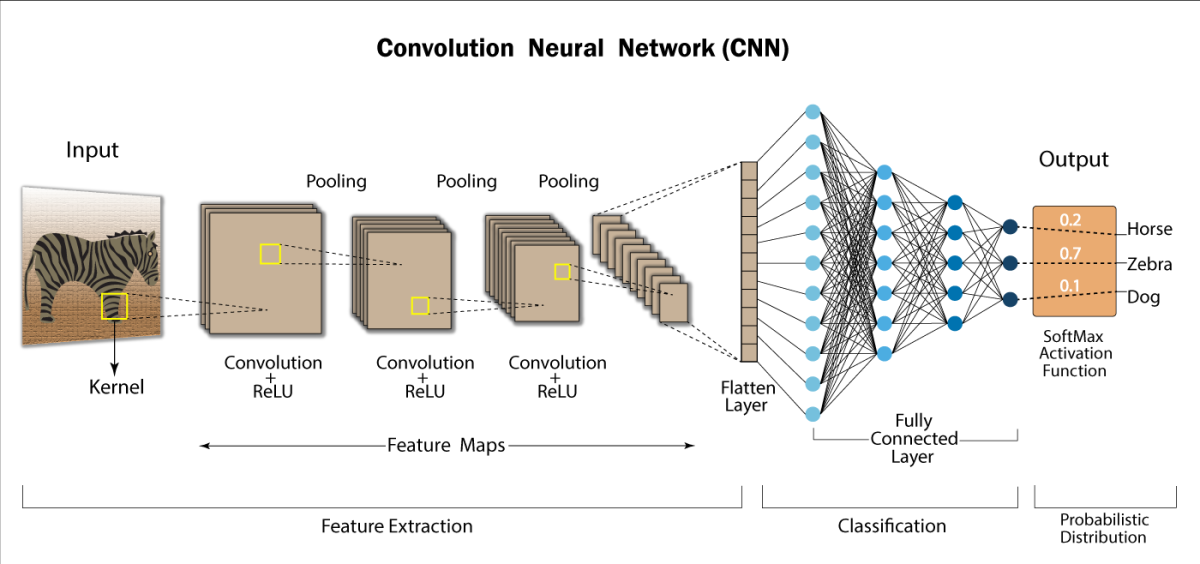


Una red neuronal convolucional es un tipo de red neuronal artificial donde las neuronas artificiales, corresponden a campos receptivos de una manera muy similar a las neuronas en la corteza visual primaria (V1) de un cerebro biológico. Este tipo de red es una variación de un perceptron multicapa, sin embargo, debido a que su aplicación es realizada en matrices bidimensionales, son muy efectivas para tareas de visión artificial, como en la clasificación y segmentación de imágenes, entre otras aplicaciones.


In [1]:
import numpy as np
import pandas as pd

import os
import shutil
import torch
import torchvision
from torchvision import transforms

from tqdm.notebook import tqdm

from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader
from torch.utils.data import Subset

from IPython.display import clear_output

import matplotlib.pyplot as plt

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [4]:
data = pd.read_csv("C:\\Users\\qsavy_1\\CCD\\ccd_CNN\\archive\\thumbnails\\metadata.csv")
data

,Id,Channel,Category,Title
0,OkmNXy7er84,3Blue1Brown,Science,The hardest problem on the hardest test
1,r6sGWTCMz2k,3Blue1Brown,Science,But what is a Fourier series? From heat flow t...
2,bBC-nXj3Ng4,3Blue1Brown,Science,But how does bitcoin actually work?
3,aircAruvnKk,3Blue1Brown,Science,"But what is a neural network? | Chapter 1, Dee..."
4,HEfHFsfGXjs,3Blue1Brown,Science,The most unexpected answer to a counting puzzle
...,...,...,...,...
2510,In0nB0ABaUk,Web Dev Simplified,Tech,JavaScript Form Validation
2511,y17RuWkWdn8,Web Dev Simplified,Tech,Learn DOM Manipulation In 18 Minutes
2512,O6P86uwfdR0,Web Dev Simplified,Tech,Learn useState In 15 Minutes - React Hooks Exp...
2513,DUg2SWWK18I,Web Dev Simplified,Tech,MVC Explained in 4 Minutes


In [5]:
os.listdir('archive/thumbnails/images')

['Automobile',
 'Automobile,Comedy',
 'Blog',
 'Blog,Comedy',
 'Blog,Entertainment',
 'Blog,Science',
 'Bon App├⌐tit',
 'Comedy',
 'Comedy,Entertainment',
 'Comedy,Informative',
 'Entertainment',
 'Entertainment,Blog',
 'Entertainment,Comedy',
 'Food',
 'Food,Entertainment',
 'Informative',
 'Kurzgesagt ΓÇô In a Nutshell',
 'News',
 'Science',
 'Tech',
 'Tech,Comedy',
 'Tech,Informative',
 'Tech,News',
 'VideoGames']

### Arquitectura:
Las redes neuronales convolucionales consisten en múltiples capas de filtros convolucionales de una o más dimensiones. Después de cada capa, por lo general se añade una función para realizar un mapeo causal no-lineal.

Como redes de clasificación, al principio se encuentra la fase de extracción de características, compuesta de neuronas convolucionales y de reducción de muestreo. Al final de la red se encuentran neuronas de perceptron sencillas para realizar la clasificación final sobre las características extraídas. La fase de extracción de características se asemeja al proceso estimulante en las células de la corteza visual. Esta fase se compone de capas alternas de neuronas convolucionales y neuronas de reducción de muestreo. Según progresan los datos a lo largo de esta fase, se disminuye su dimensionalidad, siendo las neuronas en capas lejanas mucho menos sensibles a perturbaciones en los datos de entrada, pero al mismo tiempo siendo estas activadas por características cada vez más complejas.
Neuronas convolucionales
En la fase de extracción de características, las neuronas sencillas de un perceptron son reemplazadas por procesadores en matriz que realizan una operación sobre los datos de imagen 2D que pasan por ellas, en lugar de un único valor numérico. La salida de cada neurona convolucional se calcula como:

${\displaystyle Y_{j}=g\left(b_{j}+\sum _{i}K_{ij}\otimes Y_{i}\right)}$

Donde la salida ${\displaystyle Y_{j}}$ de una neurona ${\displaystyle j}$ es una matriz que se calcula por medio de la combinación lineal de las salidas ${\displaystyle Y_{i}}$ de las neuronas en la capa anterior cada una de ellas operadas con el núcleo de convolucional ${\displaystyle K_{ij}}$ correspondiente a esa conexión. Esta cantidad es sumada a una influencia ${\displaystyle b_{j}}$ y luego se pasa por una función de activación ${\displaystyle g(\cdot )}$ no-lineal.

El operador de convolución tiene el efecto de filtrar la imagen de entrada con un núcleo previamente entrenado. Esto transforma los datos de tal manera que ciertas características (determinadas por la forma del núcleo) se vuelven más dominantes en la imagen de salida al tener estas un valor numérico más alto asignados a los pixeles que las representan. Estos núcleos tienen habilidades de procesamiento de imágenes específicas, como por ejemplo la detección de bordes que se puede realizar con núcleos que resaltan la gradiente en una dirección en particular. Sin embargo, los núcleos que son entrenados por una red neuronal convolucional generalmente son más complejos para poder extraer otras características más abstractas y no triviales.

In [6]:
ch2cat = {}
cur_ch = ""
for i in data[['Channel', 'Category']].values.tolist():
    if i[0] == cur_ch: continue
    cur_ch = i[0]
    ch2cat[cur_ch] = i[1]

categories = set(val for val in ch2cat.values())

In [7]:
s = ""
for i in ch2cat.keys():
    if i == "category":
        s = i
        break
ch2cat["category"] = ch2cat[s]

In [8]:
basedir = "C:/Users/qsavy_1/CCD/ccd_CNN/archive/thumbnails/images/"

for fn in os.listdir(basedir):
    if fn not in ch2cat.keys(): continue
    try:
        os.rename(os.path.join(basedir, fn), os.path.join(basedir, ch2cat[fn]))
    except OSError:
        shutil.move(os.path.join(basedir, fn), os.path.join(basedir, ch2cat[fn]))

In [9]:
batch_size = 64

In [10]:
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

# based on https://gist.github.com/srikarplus/8bdb5bedf0ca25e894e39ea78fce2f39
def get_train_valid_loader(data_dir,
                           batch_size,
                           augment,
                           random_seed,
                           valid_size=0.1,
                           shuffle=True,
                           show_sample=False,
                           num_workers=4,
                           pin_memory=False):
    """
    
    Params
    ------
    - data_dir: path directory to the dataset.
    - batch_size: how many samples per batch to load.
    - augment: whether to apply the data augmentation scheme
      mentioned in the paper. Only applied on the train split.
    - random_seed: fix seed for reproducibility.
    - valid_size: percentage split of the training set used for
      the validation set. Should be a float in the range [0, 1].
    - shuffle: whether to shuffle the train/validation indices.
    - show_sample: plot 9x9 sample grid of the dataset.
    - num_workers: number of subprocesses to use when loading the dataset.
    - pin_memory: whether to copy tensors into CUDA pinned memory. Set it to
      True if using GPU.
    Returns
    -------
    - train_loader: training set iterator.
    - valid_loader: validation set iterator.
    """
    error_msg = "[!] valid_size should be in the range [0, 1]."
    assert ((valid_size >= 0) and (valid_size <= 1)), error_msg

    normalize = transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )

    # define transforms
    valid_transform = transforms.Compose([transforms.Resize(512),
                                      transforms.ToTensor(),
                                      normalize])

    train_transform = transforms.Compose([transforms.Resize(512),
                                      transforms.ToTensor(),
                                      normalize])

    # load the dataset
    train_dataset = datasets.ImageFolder(
        root=data_dir, transform=train_transform,
    )

    valid_dataset = datasets.ImageFolder(
        root=data_dir, transform=valid_transform,
    )

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    if shuffle:
        np.random.seed(random_seed)
        np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, sampler=train_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )
    valid_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=batch_size, sampler=valid_sampler,
        num_workers=num_workers, pin_memory=pin_memory,
    )


    return (train_loader, valid_loader, train_dataset.class_to_idx)

In [11]:
train_loader, test_loader, class_idx = get_train_valid_loader("C:/Users/qsavy_1/CCD/ccd_CNN/archive/thumbnails/images/", batch_size, False, 42, 0.1)

In [12]:
class_idx

{'Automobile': 0,
 'Automobile,Comedy': 1,
 'Blog': 2,
 'Blog,Comedy': 3,
 'Blog,Entertainment': 4,
 'Blog,Science': 5,
 'Bon App├⌐tit': 6,
 'Comedy': 7,
 'Comedy,Entertainment': 8,
 'Comedy,Informative': 9,
 'Entertainment': 10,
 'Entertainment,Blog': 11,
 'Entertainment,Comedy': 12,
 'Food': 13,
 'Food,Entertainment': 14,
 'Informative': 15,
 'Kurzgesagt ΓÇô In a Nutshell': 16,
 'News': 17,
 'Science': 18,
 'Tech': 19,
 'Tech,Comedy': 20,
 'Tech,Informative': 21,
 'Tech,News': 22,
 'VideoGames': 23}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
C:\Users\qsavy_1\.conda\envs\torch_py\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


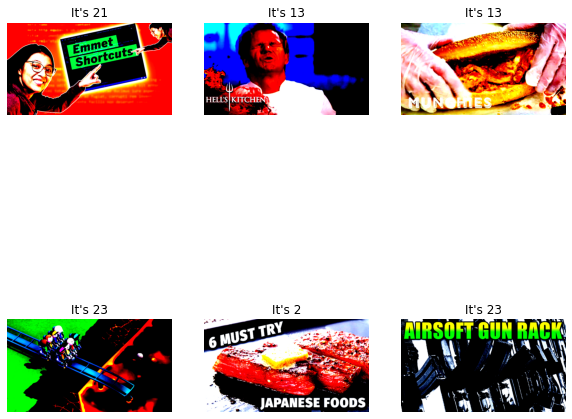

In [13]:
fig, ax = plt.subplots(2, 3, figsize=(10, 10))
for image, number in train_loader:
    for i in range(2):
        for j in range(3):
            ax[i, j].imshow(image[i * 3 + j].permute(1, 2, 0))
            ax[i, j].set_title(f'It\'s {number[i * 3 + j]}')
            ax[i, j].axis('off')
    break
fig.show()

In [14]:
# prepare model:
class Model(nn.Module):
    def __init__(self, out_features = 23):
        super().__init__()
        self.blocks = nn.Sequential(
            nn.Conv2d(3, 16, 5, 3, 2),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 5, 3, 1),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 3, 1),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 3, 1),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(512*3*7, 256*3*7),
            nn.ReLU(),
            nn.Linear(256*3*7, 128*3*7),
            nn.ReLU(),
            nn.Linear(128*3*7, out_features)
        )
    
    def forward(self, x):
        return self.blocks(x)


In [15]:
#!g1.1
model = Model(len(categories))
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()
n_epochs = 100

In [16]:
model.to(device)

Model(
  (blocks): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(3, 3), padding=(2, 2))
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (4): Dropout(p=0.2, inplace=False)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (7): Dropout(p=0.2, inplace=False)
    (8): ReLU()
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (10): Dropout(p=0.2, inplace=False)
    (11): ReLU()
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=10752, out_features=5376, bias=True)
    (14): ReLU()
    (15): Linear(in_features=5376, out_features=2688, bias=True)
    (16): ReLU()
    (17): Linear(in_features=2688, out_features=22, bias=True)
  )
)

In [17]:
# train
from IPython.display import clear_output
def plot_loss_accuracy(train_losses, train_accs, test_accs, n):
    clear_output()
    fig, ax = plt.subplots(1, 2, figsize=(26,10))
    ax[0].set_title(f'Train Loss, epoch {n}')
    ax[0].plot(train_losses)
    ax[1].set_title('Accuracy')
    ax[1].plot(train_accs, label='Train')
    ax[1].plot(test_accs, label='Test')
    ax[1].legend()
    plt.grid()
    plt.show()

In [18]:
#!g1.1
def train_epoch(model, train_loader, criterion, optimizer, device='cpu',):
    model.train()
    train_losses = []
    train_accuracy = []

    for batch_X, batch_Y in tqdm(train_loader):
        batch_X = batch_X.to(device)
        batch_Y = batch_Y.to(device)

        optimizer.zero_grad()

        softmax = nn.Softmax()
        probs = softmax(model(batch_X))
        classes = torch.argmax(probs, dim=-1)
        loss = criterion(probs, batch_Y)

        loss.backward()

        train_losses.append(loss.item())
        train_accuracy.append((classes == batch_Y).float().mean().item())
        optimizer.step()
    
    return np.mean(train_losses), np.mean(train_accuracy)


def predict(model, test_loader, criterion, device='cpu'):
    model.eval()
    test_accuracy = []
    with torch.no_grad():
        for batch_X, batch_Y in tqdm(test_loader):
            batch_X = batch_X.to(device)
            batch_Y = batch_Y.to(device)

            softmax = nn.Softmax()
            probs = softmax(model(batch_X))
            classes = torch.argmax(probs, dim=-1)
            
            test_accuracy.append((classes == batch_Y).float().mean().item())
    return np.mean(test_accuracy)


def train(model, train_loader, test_loader, criterion, optimizer, n_epochs, device='cpu'):
    train_losses = []
    train_accs = []
    test_accs = []

    for epoch in range(n_epochs):
        loss, accs = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(loss)
        train_accs.append(accs)
        test_accs.append(predict(model, test_loader, criterion, device))
        plot_loss_accuracy(train_losses, train_accs, test_accs, epoch)

###  Generacion de algoritmo

El resultado predictivo de este modelo no cumplio los criterios para ser puesto en la página web ya que el modelo más optimizado que pudimos lograr tuvo una correlación del 33%, lo cual se lo atribuimos a 2 razones principales: la primera es que no contamos con una base de imágenes de thumbnails lo suficientemente robusta para que el modelo pueda encontrar una correlación adecuada y la segunda es por la tendencia actual de Youtube en cuanto a la estética de los thumbnails. El clima actual ha logrado que todas las categorías de los canales comparten un patrón similar. 

No obstante,  vamos a seguir incrementando nuestras bases de datos para poder mejorar nuestro modelo predictivo por categorías.

Es importante notar que la implementación de una red neuronal en áreas nuevas toma tiempo, siempre se pueden mejorar y modificar, esto es debido a que las predicciones son dependientes al tamaño de la muestra/


In [ ]:
import warnings
warnings.filterwarnings("ignore")
train(model, train_loader, test_loader, criterion, optimizer, n_epochs, device)

 ### 3)  Desarrollo de modelo predictivo para la estructura de encabezados de alto impacto 
 
 El siguiente bloque de celdas de código describen cómo fueron desarrolladas las herramientas para generar nuestro modelo de procesamiento de lenguaje nativo, dentro de el proceso se demuestra cómo se generó un pipeline con las funciones de remover los stopwords, parsear y tokenizar las palabras, con el fin de posibilitar el procesamiento de lenguaje, finalmente fueron vectorizadas para generar las herramientas que posibiliten estas funciones:

   Analizar titulos similares y relacionarlo con views
   Buscar palabras similares a una ingresada y ordenarla segun los trends de google
   Mostrar categorias a las que pertenece un titulo


In [7]:
# Datos de entrenamiento NLP
import pandas as pd
import spacy
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download('stopwords')
nltk.download('punkt')

spacy.prefer_gpu()
nlp = spacy.load('es_core_news_md')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\qsavy_1\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\qsavy_1\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [8]:
stops = set(stopwords.words('spanish'))

In [9]:
df = pd.read_csv('video_data_final.csv')

In [10]:
title = df['title']
stop_words = set(stopwords.words('spanish'))
df['title_no_stopwords'] = df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])
df['title_no_stopwords'] = df['title'].str.replace('\n','')
df['title_no_stopwords'] = df['title'].str.replace('\w*\d\w*', '')
df['title_no_stopwords'] = df['title'].str.replace('[''""_]','')
df['title_no_stopwords'] = df['title'].str.replace('[^\w\s]','')
df['title_no_stopwords'] = df['title'].str.replace('[[]]','')
df['title_no_stopwords'] = df['title'].str.replace('\d*,\d','')
df['title_no_stopwords'] = df['title'].str.replace('\d*,','')

C:\Users\qsavy_1\AppData\Local\Temp\ipykernel_16552\3557328382.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title_no_stopwords'] = df['title'].str.replace('\w*\d\w*', '')
C:\Users\qsavy_1\AppData\Local\Temp\ipykernel_16552\3557328382.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title_no_stopwords'] = df['title'].str.replace('[''""_]','')
C:\Users\qsavy_1\AppData\Local\Temp\ipykernel_16552\3557328382.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title_no_stopwords'] = df['title'].str.replace('[^\w\s]','')
C:\Users\qsavy_1\AppData\Local\Temp\ipykernel_16552\3557328382.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['title_no_stopwords'] = df['title'].str.replace('[[]]','')
C:\Users\qsavy_1\.conda\envs\scraper\lib\site-packages\pandas\core\strings\object

In [ ]:
title = df['title']
title_list = title.values.tolist()
all_words_str = ' '.join(title_list)
all_words_str

In [12]:
doc = nlp(all_words_str)

In [13]:
your_word = 'arte'

ms = nlp.vocab.vectors.most_similar(np.asarray([nlp.vocab.vectors[nlp.vocab.strings[your_word]]]), n=50)
words = [nlp.vocab.strings[w] for w in ms[0][0]]
distances = ms[2]
print(words)

['artejo', 'post-modernista', 'artística-', 'D’Addario', 'clitoriana', 'Novoartis', 'Filarmónicas', 'artes', 'marroquinera', 'psicoticismo', 'escula', 'parnasiano', 'revivalismo', 'novelería', 'teatro-danza', 'Ecoculture', 'aquitectura', 'pinturita', 'historietística', 'tenísticos', 'sertorianas', 'coleccionador', 'Mulieris', 'Alucine', 'contemporÃ¡neos', 'suntuaria', 'MundoCreativa', 'fisonómico', 'imserso', 'quattrocento', 'Alkimia', 'procreativo', 'Utópica', 'Artecoon', 'contextualismo', 'Sestil', 'culturale', 'fotográfos', 'tanatoestética', 'imaginerías', 'periodis-', 'Bioestratigrafía', 'Prerrenacimiento', 'Pintér', 'Creatividad', 'conocible', 'tertulianas', 'filosofan', 'sintagmático', 'astronomico']


In [ ]:
# Lista de tokens
for token in doc[:10]:
    print (token)

In [ ]:
doc[0:10]

In [ ]:
type(doc.sents)

In [15]:
title = df['title'][5]
title

'¡NADIE ENCUENTRA A TROLLINO ESCONDIDO EN EL CUBO DE LA BASURA! 🙈😂 EL ESCONDITE CON LOS COMPAS'

In [16]:
doc2 = nlp(title)

In [17]:
for ent in doc2.ents:
    print (ent.text, ent.label_)

TROLLINO MISC
EL CUBO DE LA BASURA! MISC
EL ESCONDITE MISC


In [ ]:
from spacy import displacy
displacy.render(doc, style='ent')

In [19]:
def compare_title(input_title,row_title,index = 0):
    input_doc = nlp(input_title)
    #ompare_doc = nlp(df['title'][index])
    compare_doc = nlp(row_title)
    return input_doc.similarity(compare_doc)

In [20]:
df_titles = df[['title', 'viewCount']]
df_titles.head()

,title,viewCount
0,¡PASAMOS de TIENDA de MASCOTAS NOOB a TIENDA d...,819935.0
1,¡HACKER NOS ENCIERRA EN LA PRISIÓN DE BEDROCK!...,3900502.0
2,¡NO ENCUENTRO a LYNA en el LABERINTO! 😱 JUGAMO...,2827316.0
3,¡PASAMOS de GRANJA NOOB a GRANJA PRO en ROBLOX...,2692418.0
4,¡Me ESCONDO DENTRO de una MESA DE CRAFTEO! 😂 E...,4171162.0


In [21]:
input_text = 'receta de tacos'
df_titles['compare'] = df_titles.apply(lambda row: compare_title(input_text,row.title),axis=1)

C:\Users\qsavy_1\AppData\Local\Temp\ipykernel_16552\3549386062.py:5: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  return input_doc.similarity(compare_doc)
C:\Users\qsavy_1\AppData\Local\Temp\ipykernel_16552\2645288195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_titles['compare'] = df_titles.apply(lambda row: compare_title(input_text,row.title),axis=1)


In [22]:
df_titles.sort_values(by='compare', ascending=[False])

,title,viewCount,compare
1836,Receta de la salsa Valentina,14073.0,0.713675
2104,Trucazos de google,15366.0,0.711768
1861,Puré de papa con sabritas,5783.0,0.710790
985,"INCREÍBLE: Banda de atracadores, Callo en mano...",66570.0,0.688863
2210,"INCREÍBLE: Banda de atracadores, Callo en mano...",67393.0,0.688863
...,...,...,...
514,Si Me Rio SE ACABA EL VIDEO,14095921.0,-0.196721
1041,Obi Wan Kenobi Capítulo 4 TODO EXPLICADO – Sta...,197074.0,-0.198423
1142,¿Cómo Spiderman 4 Podría Ser Mejor que No Way ...,14015.0,-0.201364
1052,Jedi Survivor Trailer TODO EXPLICADO – Cal Kes...,197283.0,-0.205597


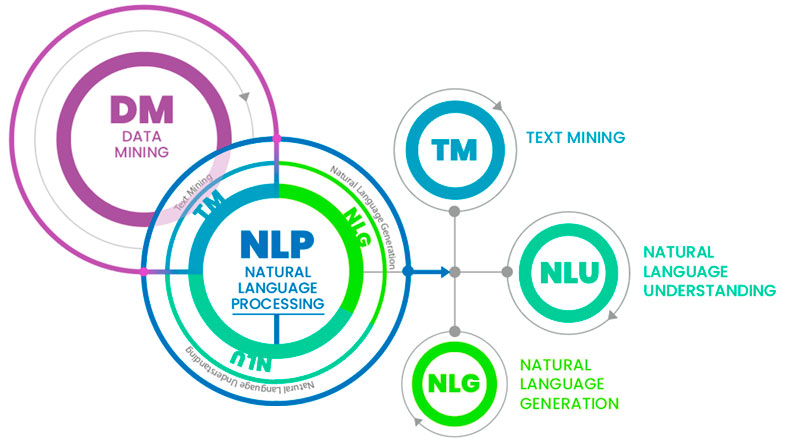

### 4 ) Desarrollo de modelo predictivo para el análisis de sentimientos

El desarrollo del siguiente modelo predictivo tiene el objetivo de poder procesar comentarios de algún creador de contenido y obtener una distribución del espectro de sentimientos de la audiencia, de esta manera el creador de contenido podrá determinar cuál es la percepción estadística de su canal cuando toca tópicos específicos para desarrollar su producto.
 cuenta con los siguientes componentes:
 Análisis morfológico. El análisis de las palabras para extraer raíces, rasgos flexivos, unidades léxicas compuestas y otros fenómenos.
 
Análisis sintáctico. El análisis de la estructura sintáctica de la frase mediante una gramática de la lengua en cuestión.

Análisis semántico. La extracción del significado de la frase, y la resolución de ambigüedades léxicas y estructurales.

Análisis pragmático. El análisis del texto más allá de los límites de la frase, por ejemplo, para determinar los antecedentes referenciales de los pronombres.

Planificación de la frase. Estructurar cada frase del texto con el fin de expresar el significado adecuado.


In [ ]:
# ML Packages
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import accuracy_score 
from sklearn.base import TransformerMixin 
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

In [ ]:
#Custom transformer using spaCy 
class predictors(TransformerMixin):
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Basic function to clean the text 
def clean_text(text):     
    return text.strip().lower()

In [ ]:
# Vectorization
vectorizer = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,1)) 
classifier = LinearSVC()

In [ ]:
# Using Tfidf
tfvectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, ylabels, test_size=0.2, random_state=42)

In [ ]:
# Create the  pipeline to clean, tokenize, vectorize, and classify 
pipe = Pipeline([("cleaner", predictors()),
                 ('vectorizer', vectorizer),
                 ('classifier', classifier)])

In [ ]:
pipe.fit(X_train,y_train)

In [ ]:
sample_prediction = pipe.predict(X_test)

In [31]:
predictions = pd.read_csv('kaggle_ready.csv')
predictions.drop('Unnamed: 0', axis=1, inplace=True)
predictions

,video_id,comments,comments_no_stopwords,FACILITY,LOCATION,GPE,ORGANIZATION,O,GSP,PERSON,sentiment
0,t0OzUTYAYSg,Súper canelo,NaN,0.0,0.0,1.0,0.0,0,0.0,0.0,0.960916
1,t0OzUTYAYSg,Súper,NaN,0.0,0.0,1.0,0.0,0,0.0,0.0,0.724248
2,t0OzUTYAYSg,CANELO A DE SER DEL PRI SOLO SABE ROBAR Y HACE...,NaN,0.0,0.0,1.0,0.0,0,0.0,0.0,-0.826602
3,t0OzUTYAYSg,Hace rato se aventaron un tiro aquí en mi barr...,NaN,0.0,0.0,1.0,0.0,0,0.0,0.0,-0.451442
4,t0OzUTYAYSg,Boxeo decadente..,NaN,0.0,0.0,1.0,0.0,0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
36758,mJ_aytTDcdQ,Que boludez es competencia no baile jaja y esa...,NaN,0.0,0.0,2.0,1.0,0,0.0,1.0,-2.000000
36759,mJ_aytTDcdQ,Vamos combatientes a ganar hoy 😍😍😍❤️💚,NaN,0.0,0.0,2.0,1.0,0,0.0,1.0,-2.000000
36760,cPZT6Kq6DZ8,"NOMÁS LES DIGO, VALE LA PENA CADA SEGUNDO DE E...",NaN,0.0,0.0,1.0,0.0,0,0.0,1.0,-2.000000
36761,cPZT6Kq6DZ8,"Dinamita: de los mejóres!!! deva o no ""impue...",NaN,0.0,0.0,1.0,0.0,0,0.0,1.0,-2.000000
